## Importación de las librerías

In [2]:
import utils
import pickle
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

## Conjuntos de entrenamiento y test y CV controller

In [3]:
X_train, X_test, y_train, y_test = utils.get_train_test_data()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7776, 12) (1022, 12) (7776,) (1022,)


In [4]:
cv = utils.get_stratified_shuffle_cv()
print(cv)

StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8)


## Búsqueda de la red neuronal

Número de parámetros (teórico): h(k+1)+h+1
- h=nodos_ocultos --> A DETERMINAR
- k=nodos_input --> 12

Esperamos 20 observaciones/parámetro
Observaciones en train: 7776

7776/20 = h(12+1)+h+1

389-1 = 14h

h = 28 nodos máximos teóricos

El tol por defecto es 0.0001 con n_iters_no_change=10 que significa si el modelo no merjora el score en tol para las iteraciones dadas se detiene el entrenamiento. Para el tuneo del modelo final lo pondremos en 0.005 --> 0.5% de mejora cada 10 iteraciones, para no sobreajustar el modelo demasiado ya que hemos puesto el número de iteraciones en 1000

In [5]:
param_grid = {
    'hidden_layer_sizes': [(i,) for i in range(3,100,5)] ,
    'learning_rate_init': [0.001, 0.01, 0.1] 
}

grid_search_cv = GridSearchCV(
    MLPClassifier(activation='relu', solver='adam', max_iter=1000, tol=0.005, random_state=99),
    param_grid=param_grid, scoring='roc_auc', cv=cv, verbose=0, n_jobs=-1 
)

grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8),
             estimator=MLPClassifier(max_iter=1000, random_state=99, tol=0.005),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(3,), (8,), (13,), (18,), (23,),
                                                (28,), (33,), (38,), (43,),
                                                (48,), (53,), (58,), (63,),
                                                (68,), (73,), (78,), (83,),
                                                (88,), (93,), (98,)],
                         'learning_rate_init': [0.001, 0.01, 0.1]},
             scoring='roc_auc')

Escogemos el **learning_rate** de **0.001** (modelo con menor complejidad) y a continuación intentamos determinar el número de nodos óptimos que parece estar entre 20 y 80. 

<AxesSubplot:xlabel='hidden_nodes', ylabel='mean_test_score'>

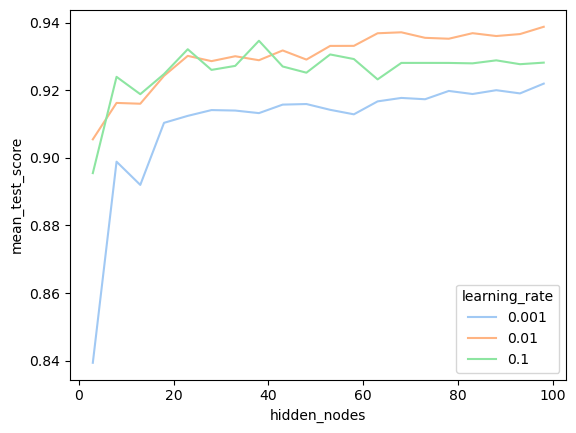

In [6]:
hidden_nodes_list = [i[0] for i in grid_search_cv.cv_results_['param_hidden_layer_sizes'].data]
learning_rate_list = list(grid_search_cv.cv_results_['param_learning_rate_init'].data)
mean_test_score_list = list(grid_search_cv.cv_results_['mean_test_score'])
nn_df = pd.DataFrame(list(zip(hidden_nodes_list, learning_rate_list, mean_test_score_list)),
                     columns=['hidden_nodes', 'learning_rate', 'mean_test_score'])
sns.lineplot(data=nn_df, x="hidden_nodes", y="mean_test_score", hue='learning_rate', legend="full", palette="pastel")

Buscamos el número de nodos optimos

In [35]:
param_grid = {
    'hidden_layer_sizes': [(i,) for i in range(20,80,3)] 
}

grid_search_cv = GridSearchCV(
    MLPClassifier(activation='relu', solver='adam', learning_rate_init=0.001, max_iter=1000, tol=0.005, random_state=99),
    param_grid=param_grid, scoring='roc_auc', cv=cv, verbose=0, n_jobs=-1
)

grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8),
             estimator=MLPClassifier(max_iter=1000, random_state=99, tol=0.005),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(20,), (23,), (26,), (29,),
                                                (32,), (35,), (38,), (41,),
                                                (44,), (47,), (50,), (53,),
                                                (56,), (59,), (62,), (65,),
                                                (68,), (71,), (74,), (77,)]},
             scoring='roc_auc')

Elegimos 40 nodos para el modelo final, básicamente por prueba y error

<AxesSubplot:xlabel='hidden_nodes', ylabel='mean_test_score'>

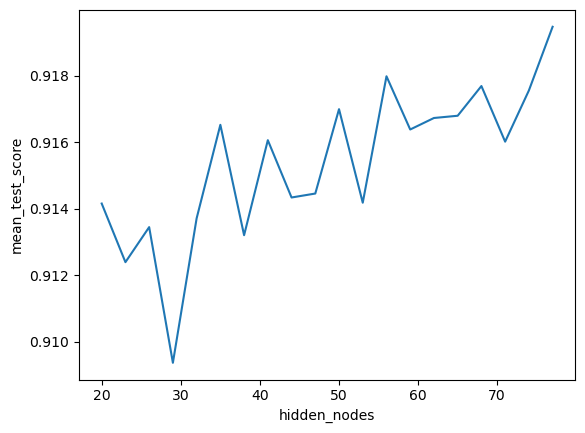

In [36]:
hidden_nodes_list = [i[0] for i in grid_search_cv.cv_results_['param_hidden_layer_sizes'].data]
mean_test_score_list = list(grid_search_cv.cv_results_['mean_test_score'])
nn_df = pd.DataFrame(list(zip(hidden_nodes_list, mean_test_score_list)),
                     columns=['hidden_nodes', 'mean_test_score'])
sns.lineplot(data=nn_df, x="hidden_nodes", y="mean_test_score")

In [37]:
nn_df

,hidden_nodes,mean_test_score
0,20,0.914159
1,23,0.912394
2,26,0.913449
3,29,0.909364
4,32,0.913713
5,35,0.916529
6,38,0.913206
7,41,0.916067
8,44,0.914341
9,47,0.914460


## Model de red neuronal

Confusion matrix, without normalization
[[762 210]
 [ 13  37]]


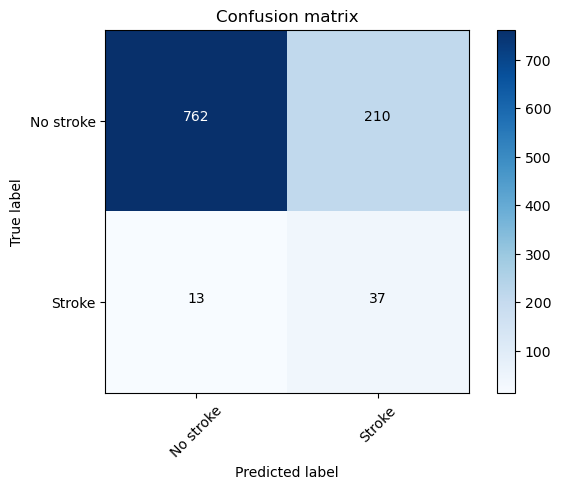

In [56]:
nn_model = MLPClassifier(activation='relu', solver='adam', hidden_layer_sizes=(40,),
                         learning_rate_init=0.001, max_iter=1000, tol=0.005, random_state=99)

nn_model.fit(X_train, y_train)
y_pred = nn_model.predict(X_test)

cm = utils.get_confusion_matrix(y_test, y_pred)
utils.plot_confusion_matrix(cm=cm, classes=['No stroke', 'Stroke'])


              precision    recall  f1-score   support

           0       0.98      0.78      0.87       972
           1       0.15      0.74      0.25        50

    accuracy                           0.78      1022
   macro avg       0.57      0.76      0.56      1022
weighted avg       0.94      0.78      0.84      1022



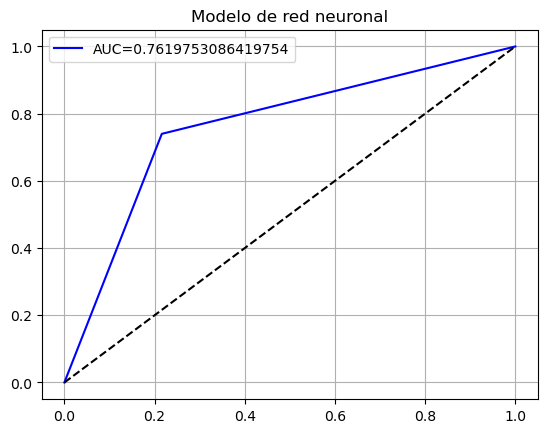

In [57]:
utils.print_metrics(y_test, y_pred, "Modelo de red neuronal")

## Importancia de las variables